# Utils

In [1]:
# conda install pytorch torchvision torchaudio cudatoolkit=11.0 -c pytorch -c nvidia

In [2]:
# credit to: https://towardsdatascience.com/building-your-own-object-detector-pytorch-vs-tensorflow-and-how-to-even-get-started-1d314691d4ae

In [3]:
%load_ext autoreload
%autoreload 2

In [23]:
import pycocotools
from PIL import Image, ExifTags
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from glob import glob
from skimage import transform

import torch
import torch.utils.data
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [5]:
class KITTIDataset(torch.utils.data.Dataset):
    
    def __init__(self, img_dir, label_dir, label_map, transforms=None):
        super().__init__()
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.img_paths = glob(os.path.join(img_dir, "*.jpg"))  
        self.label_map = label_map        
                
    def parse_kitti(self, path):
        # https://github.com/NVIDIA/DIGITS/blob/v4.0.0-rc.3/digits/extensions/data/objectDetection/README.md
        objects = []
        with open(path, 'r') as f:
            for line in [l.strip() for l in f.readlines()]:
                label, _, _, _, xmin, ymin, xmax, ymax, *_ = line.split()
                objects.append({'label': label, 'bounds': [float(x) for x in [xmin, ymin, xmax, ymax]]})            
        return objects            
            
    def __getitem__(self, idx):
        
        # load images and bounding boxes        
        img_path = self.img_paths[idx]
        img_id, _ = os.path.splitext(os.path.basename(img_path))        
        label_path = os.path.join(self.label_dir, img_id + ".txt")
                
        img = Image.open(img_path).convert("RGB")
                        
        objects = self.parse_kitti(label_path)                
        boxes = torch.tensor([o['bounds'] for o in objects], dtype=torch.float32)
        labels = torch.tensor([self.label_map[o['label']] for o in objects], dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])
        target["iscrowd"] = torch.zeros((len(objects),), dtype=torch.int64)
        #target["filename"] = img_path
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        return img, target
    
    def __len__(self):
        return len(self.img_paths)

In [6]:
def get_transforms(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))        
        #transforms.append(T.RandomVerticalFlip(0.5)) 
    return T.Compose(transforms)

In [7]:
def get_model(num_classes, pretrained=False):
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new on
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [8]:
def display_annotation(image, target, label_map, prediction=None, thresh=0, size=None, title=""):
    
    # invert labelmap
    label_map = {v:k for k,v in label_map.items()}
    
    label_offset_x = 0
    label_offset_y = -2
    fig, ax = plt.subplots(figsize=size)   
    image = image.permute(1, 2, 0).cpu().numpy()
    
    # image resize
    #width, height, channels = image.shape
    #image = transform.resize(image, (2*width, 2*height))
    
    ax.imshow(image) # assumes image is a torch.tensor
    
    # ground truth
    boxes = target['boxes']    
    for i in range(boxes.size()[0]):
        x1, y1, x2, y2 = target['boxes'][i]
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')    
        ax.add_patch(rect)
        ax.text(x1 + label_offset_x, y1 + label_offset_y, f"{label_map[target['labels'][i].item()]}", color='r')
        if title:
            ax.set_title(title)
        
    # prediction
    if prediction:
        boxes, scores, labels = prediction['boxes'], prediction['scores'], prediction['labels']
        for i in range(boxes.size()[0]):            
            if scores[i] > thresh:
                x1, y1, x2, y2 = boxes[i]
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='g', facecolor='none')    
                ax.add_patch(rect)  
                text = f"{label_map[labels[i].item()]} {scores[i]:.2f}"
                ax.text(x1 + label_offset_x, y2 - 6*label_offset_y, text, color='g')
    plt.show()        

# Workflow

In [9]:
data_dir = "../KITTI_Test/data/combined/resized" # these are the scaled images used for training
image_dir = os.path.join(data_dir, "images")
label_dir = os.path.join(data_dir, "labels")

# need a default background class
label_map = {
    'background': 0,
    'core': 1,
    'flake': 2,
    'flake_broken': 3,
    'tool': 4
}

# define datasets
ds = KITTIDataset(image_dir, label_dir, label_map, transforms=get_transforms(train=True))
ds_test = KITTIDataset(image_dir, label_dir, label_map, transforms=get_transforms(train=False))

### Data Review

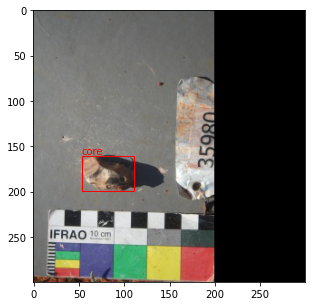

In [10]:
# check example test image
image, target = ds_test[0]
display_annotation(image, target, label_map, size=(5, 5))

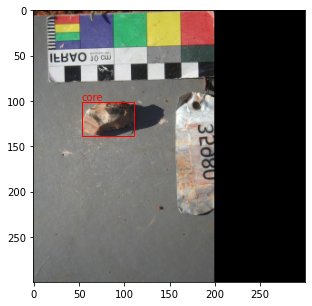

In [26]:
import transforms as T

# check transformations
image, target = ds_test[0]

transforms = [
    #T.RandomHorizontalFlip(0.5),
    T.RandomVerticalFlip(0.5),
]
transforms = T.Compose(transforms)
image, target = transforms(image, target)

display_annotation(image, target, label_map, size=(5, 5))

/home/ubuntu/miniconda3/envs/kitti/lib/python3.7/site-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


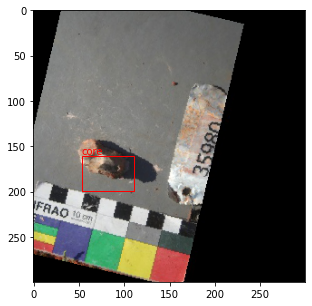

In [44]:
import torchvision.transforms as tt

# check transformations
image, target = ds_test[0]

t = tt.RandomAffine([0, 90])

image = t(image)

display_annotation(image, target, label_map, size=(5, 5))

In [41]:
torch.rot90(image)

tensor([[[0.4000, 0.4000, 0.4549,  ..., 0.0000, 0.0000, 0.0000],
         [0.1529, 0.1294, 0.1725,  ..., 0.0000, 0.0000, 0.0000],
         [0.0941, 0.0667, 0.1176,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.3961, 0.3725, 0.3608,  ..., 0.0000, 0.0000, 0.0000],
         [0.1686, 0.1412, 0.1294,  ..., 0.0000, 0.0000, 0.0000],
         [0.1216, 0.0863, 0.0745,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.3333, 0.2235, 0.3216,  ..., 0.0000, 0.0000, 0.0000],
         [0.1412, 0.0549, 0.1490,  ..., 0.0000, 0.0000, 0.0000],
         [0.1216, 0.0196, 0.1059,  ..., 0.0000, 0.0000, 0.0000]],

        ...,

        [[0.4118, 0.4314, 0.4275,  ..., 0.0000, 0.0000, 0.0000],
         [0.4196, 0.4392, 0.4353,  ..., 0.0000, 0.0000, 0.0000],
         [0.4157, 0.4353, 0.4314,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.4314, 0.4275, 0.4118,  ..., 0.0000, 0.0000, 0.0000],
         [0.4392, 0.4353, 0.4196,  ..., 0.0000, 0.0000, 0.0000],
         [0.4353, 0.4314, 0.4157,  ..., 0.0000, 0.0000, 0.0000]],

 

In [17]:
dir(T)

['Compose',
 'F',
 'RandomHorizontalFlip',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_flip_coco_person_keypoints',
 'random']

In [160]:
# # check all images
# for i, path in enumerate(ds.img_paths):
#     image, target = ds[i]    
#     display_annotation(image, target, label_map, title=f"[{i}]: {path}")

### Data Partitioning

In [161]:
# split into train and test
n_test = 40
torch.manual_seed(1)
indices = torch.randperm(len(ds)).tolist()
ds = torch.utils.data.Subset(ds, indices[:-n_test])
ds_test = torch.utils.data.Subset(ds_test, indices[-n_test:])

# define data loaders
dl = torch.utils.data.DataLoader(ds, batch_size=4, shuffle=True, num_workers=1, collate_fn=utils.collate_fn)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=1, shuffle=False, num_workers=1, collate_fn=utils.collate_fn)
print(f"Total {len(indices)} samples, train: {len(ds)}, test: {len(ds_test)}")

Total 398 samples, train: 358, test: 40


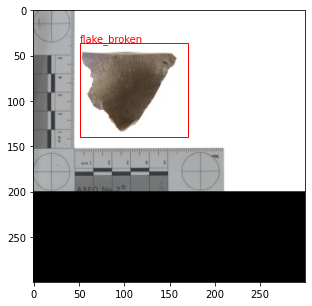

In [162]:
# check example test image
image, target = ds_test[1]
display_annotation(image, target, label_map, size=(5, 5))

# Training

In [163]:
# # check all test images
# for i in range(n_test):
#     image, target = ds_test[i]
#     display_annotation(image, target, label_map)

In [164]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')
print('device:', device)

device: cuda


In [168]:
model = get_model(len(label_map)).to(device)

In [169]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(params, lr=0.001)
# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
epochs = 80
for e in range(epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, dl, device, e, print_freq=32, grad_clip=1)
    # update the learning rate
    #lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, dl_test, device=device)

Epoch: [0]  [ 0/90]  eta: 0:00:39  lr: 0.000012  loss: 2.3921 (2.3921)  loss_classifier: 1.6439 (1.6439)  loss_box_reg: 0.0442 (0.0442)  loss_objectness: 0.6940 (0.6940)  loss_rpn_box_reg: 0.0101 (0.0101)  time: 0.4434  data: 0.1147  max mem: 4917
Epoch: [0]  [32/90]  eta: 0:00:18  lr: 0.000371  loss: 0.3156 (0.8111)  loss_classifier: 0.1509 (0.4942)  loss_box_reg: 0.1052 (0.0902)  loss_objectness: 0.0310 (0.2200)  loss_rpn_box_reg: 0.0063 (0.0067)  time: 0.3082  data: 0.0073  max mem: 5341
Epoch: [0]  [64/90]  eta: 0:00:08  lr: 0.000731  loss: 0.3418 (0.5937)  loss_classifier: 0.1849 (0.3480)  loss_box_reg: 0.1206 (0.1095)  loss_objectness: 0.0303 (0.1285)  loss_rpn_box_reg: 0.0088 (0.0077)  time: 0.3098  data: 0.0081  max mem: 5341
Epoch: [0]  [89/90]  eta: 0:00:00  lr: 0.001000  loss: 0.3244 (0.5171)  loss_classifier: 0.1684 (0.2961)  loss_box_reg: 0.1270 (0.1132)  loss_objectness: 0.0207 (0.0997)  loss_rpn_box_reg: 0.0073 (0.0081)  time: 0.3017  data: 0.0085  max mem: 5341
Epoch: [

Epoch: [8]  [ 0/90]  eta: 0:00:36  lr: 0.001000  loss: 0.1877 (0.1877)  loss_classifier: 0.0975 (0.0975)  loss_box_reg: 0.0775 (0.0775)  loss_objectness: 0.0092 (0.0092)  loss_rpn_box_reg: 0.0035 (0.0035)  time: 0.4003  data: 0.0912  max mem: 5341
Epoch: [8]  [32/90]  eta: 0:00:18  lr: 0.001000  loss: 0.2322 (0.2454)  loss_classifier: 0.1261 (0.1303)  loss_box_reg: 0.0993 (0.1017)  loss_objectness: 0.0056 (0.0085)  loss_rpn_box_reg: 0.0039 (0.0048)  time: 0.3082  data: 0.0079  max mem: 5341
Epoch: [8]  [64/90]  eta: 0:00:08  lr: 0.001000  loss: 0.2688 (0.2586)  loss_classifier: 0.1390 (0.1379)  loss_box_reg: 0.1170 (0.1086)  loss_objectness: 0.0057 (0.0072)  loss_rpn_box_reg: 0.0035 (0.0048)  time: 0.3158  data: 0.0097  max mem: 5341
Epoch: [8]  [89/90]  eta: 0:00:00  lr: 0.001000  loss: 0.2352 (0.2530)  loss_classifier: 0.1233 (0.1343)  loss_box_reg: 0.0977 (0.1068)  loss_objectness: 0.0051 (0.0067)  loss_rpn_box_reg: 0.0055 (0.0052)  time: 0.3018  data: 0.0081  max mem: 5341
Epoch: [

### Model Saving

In [ ]:
# save the model
torch.save(model.state_dict(), "model.pt")

# Evaluation

In [ ]:
# load model
loaded_model = get_model(len(label_map))
loaded_model.load_state_dict(torch.load("model.pt"))
loaded_model = loaded_model.to(device)

In [ ]:
idx = 2 # this is the image number in the test set, 0 to n_test - 1
image, target = ds_test[idx]
reverse_label_map = {v:k for k,v in label_map.items()}

loaded_model.eval()
with torch.no_grad():
    pred = loaded_model([image.to(device)])    
    display_annotation(image, target, label_map, prediction=pred[0], thresh=0.3, size=(10, 10))
    labels, scores = pred[0]['labels'], pred[0]['scores']
    for i in range(labels.size()[-1]):
        print(reverse_label_map[labels[i].item()], "--", scores[i].item())